In [27]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy
from PIL import Image
import extcolors
import math
import skimage
from sklearn.linear_model import LinearRegression
import pandas as pd

#Detect Sky Region (small variance between px)
#Given the mask, make where the land is black
def cal_skyline(mask):
    h, w = mask.shape
    for i in range(w): #for each column
        raw = mask[:, i]
        after_median = scipy.signal.medfilt(raw, 19)
        try:
            first_zero_index = np.where(after_median == 0)[0][0]
            first_one_index = np.where(after_median == 1)[0][0]
            if first_zero_index > 20: #if the sky is bigger then 20 px starting from the top
                mask[first_one_index:first_zero_index, i] = 1 #put 1 between sky and land
                mask[first_zero_index:, i] = 0 #put 0 in land (appears black)
                mask[:first_one_index, i] = 0 #put 0 before the sky starts 
        except:
            continue
    return mask

def get_sky_region_gradient(img):
    h, w, _ = img.shape
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.blur(img_gray, (9, 3))
    img_gray= cv2.medianBlur(img_gray, 5)
    lap = cv2.Laplacian(img_gray, cv2.CV_8U)
    gradient_mask = (lap < 6).astype(np.uint8) # we keep region with small laplacian ->sky
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3))
    mask = cv2.morphologyEx(gradient_mask, cv2.MORPH_ERODE, kernel) #erosion that takes the minimum of neighbouring px
    mask_sky = cal_skyline(mask)
    after_img = cv2.bitwise_and(img, img, mask=mask_sky)
    return after_img

#Cut from the top until less then 60% of sky is detected
def cut_image_from_mask(grad_sky,img):
    low = np.array([1,1,1])
    high = np.array([256,256,256])
    masked_sky = cv2.inRange(grad_sky, low, high)
    h,w = masked_sky.shape
    i = h
    count = flag = j = 0
    img_new = img
    while((i>0) & (flag==0)):
        i=i-1 
        j = count = 0
        while(j<w):
            if (masked_sky[i,j] == 255) : # if px is sky 
                count = count + 1
            j=j+1
            if (count > (w*0.3)): #cut until 30% of the line isn't sky
                lim = i; 
                flag = 1

    img_new = img[lim:,:,:]


    #cv2.imshow('Image with Sky cut out', cv2.cvtColor(img_new, cv2.COLOR_BGR2RGB))
    #cv2.waitKey(2000)
    
    return img_new

def colors_to_array(colors_x) : 
    colors_rgb = np.zeros((len(colors_x[0]),3))
    colors_lab = np.zeros((len(colors_x[0]),3))

    for i in range(len(colors_x[0])):
        col = colors_x[0][i][0]
        colors_rgb[i]=col
        colors_lab[i] = skimage.color.rgb2lab((col[0]/255, col[1]/255, col[2]/255))

    return colors_rgb, colors_lab

def mask_vegetation(img_lab, col_lab):
    # Using inRange method, to create a mask
    thr = [8,8,8] #TO DO : maybe change  thr according to histogram ??
    lower_col = col_lab - thr
    upper_col = col_lab + thr
    mask = cv2.inRange(img_lab, lower_col, upper_col)
    return mask

def hough_line_detector(mask, img) :
    hough_thresh,hough_min_line,hough_max_gap  = [20,100,100]
    #nb pts pour qu'une ligne soit considérée
    #nb pts à la suite ds la même ligne 
    #dist entre 2 pts pour qu'ils soient reliés

    blur = cv2.medianBlur(mask,3)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(10,1))
    blur = cv2.dilate(blur, kernel)

    hough_image = np.matrix.copy(img)
    i = line_sing_col = 0

    # find the Hough lines using the PPHT method
    lines = cv2.HoughLinesP(image=blur, rho=1, theta=np.pi / 180, threshold=hough_thresh, 
                    minLineLength=hough_min_line, maxLineGap=hough_max_gap)
                    
    if lines is not None:
        line_sing_col = np.zeros((len(lines),4))
        #print("len : ", len(lines))
        #print("size line_sing_col", line_sing_col.shape)

        for x in range(0, len(lines)):
            for x1, y1, x2, y2 in lines[x]:
                if (math.atan2(abs(x1-x2),abs(y1-y2)) < (np.pi/2.5)) : 
                    #print(i)
                    line_sing_col[i,:] = lines[x]
                    i=i+1
                    hough_image = cv2.line(hough_image, (x1, y1), (x2, y2), (0, 0, 255), 1)

        line_sing_col = line_sing_col[:i,:]
    #else:
        #print("No lines")
    #cv2.imshow('HI : ', hough_image)
    #cv2.waitKey(1000)

    return i, hough_image, line_sing_col

def keep_best_mask(arr_mask, img_no_sky, colors_lab):
    max_detected = max_detected_new = 0
    hough_img = 0
    all_lines = []
    idx_best = 0

    for idx, mask in enumerate(arr_mask) : 
        max_detected_new, hough_img_new, line_sing_col_new = hough_line_detector(mask, img_no_sky)
        if (max_detected_new > max_detected) : 
            max_detected = max_detected_new
            best_mask = mask
            hough_img = hough_img_new
            line_sing_col = line_sing_col_new
            idx_best = idx
    
    print(max_detected , 'lines detected for index ', idx_best, 'with color ', colors_lab[idx_best]) 

    
    #cv2.imshow('hehehe', cv2.bitwise_and(cv2.cvtColor(img_no_sky, cv2.COLOR_BGR2RGB),img_no_sky, mask = best_mask))
    #cv2.waitKey(5000)
    #cv2.imshow('hehehe2', cv2.bitwise_and(cv2.cvtColor(img_no_sky, cv2.COLOR_BGR2RGB),img_no_sky, mask = cv2.Canny(best_mask,100,200)))

    #cv2.imshow('hellodylanhowareyoumysexyBF', best_mask)
    #cv2.waitKey(1000)
    return best_mask, colors_lab[idx_best]

def hough_line_improved(mask, angle_acc):
  # Rho and Theta ranges

    mask = cv2.medianBlur(mask,3)
    #kernel = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(2,1))
    #mask = cv2.dilate(mask, kernel)

    thetas = np.deg2rad(np.arange(0, 180))
    width, height = mask.shape
    diag_len = int(np.ceil(np.sqrt(width * width + height * height)))   # max_dist
    rhos = np.linspace(-diag_len, diag_len, num = diag_len * 2)

    # Cache some resuable values
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)

    # Hough accumulator array of theta vs rho
    accumulator = np.zeros((2 * diag_len, num_thetas), dtype=np.uint64)
    accumulator_for_pres = np.zeros((2 * diag_len, num_thetas), dtype=np.uint64)
    y_idxs, x_idxs = np.nonzero(mask)  # (row, col) indexes to edges
    #print(y_idxs, x_idxs)

    # Vote in the hough accumulator
    for i in range(len(x_idxs)):
        #print('step ', i, 'of len ', len(x_idxs))
        x = x_idxs[i]
        y = y_idxs[i]

        for t_idx in range(num_thetas):
            # Calculate rho. diag_len is added for a positive index
            rho = round(x * cos_t[t_idx] + y * sin_t[t_idx]) + diag_len
            accumulator[rho, t_idx] += 1
            accumulator_for_pres[rho, t_idx] += 1
            if (abs(np.rad2deg(thetas[t_idx])-90)<20): #if horizontale lignes 
                accumulator[:, t_idx] = 0
            
            for angle in angle_acc:
                if (abs(np.rad2deg(thetas[t_idx])-np.rad2deg(angle))<10): #if angle already detected 
                    accumulator[:, t_idx] = 0


    return accumulator, thetas, rhos

def keep_mask_max_acc_lines(best_mask_edge, img_no_sky, crop_nb):

    best_mask_edge_copy = np.copy(best_mask_edge)
    best_mask_evaluate = np.copy(best_mask_edge)
    img_no_sky_copy = np.copy(img_no_sky)

    #crop_nb = 3

    th_acc = []
    r_acc = []
    threshold_acc = []
    mask = []

    for i in range(crop_nb):
        mask_single_crop = np.zeros_like(img_no_sky)

        print('step ', (i+1), 'of ', crop_nb)
        acc, thetas, rhos = hough_line_improved(best_mask_edge_copy, th_acc)

        th_max = acc.max()

        r_idx, th_idx = np.where(acc>=th_max)
        r = rhos[r_idx[0]]#in case multiple same max 
        th = thetas[th_idx[0]]

        th_acc.append(th)
        r_acc.append(r)
        threshold_acc.append(th_max)

        a = math.cos(th)
        b = math.sin(th)
        x0 = a * r
        y0 = b * r
        p1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        p2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))

        cv2.line(best_mask_edge_copy, p1, p2, (0,0,0), 25)
        cv2.line(best_mask_evaluate, p1, p2, (255,0,0), 3)
        cv2.line(img_no_sky_copy, p1, p2, (255,0,0), 3)
        cv2.line(mask_single_crop, p1, p2, (255,0,0), 40)
        mask.append(mask_single_crop)
    
    #cv2.imshow('HL ', img_no_sky_copy)
    #cv2.waitKey(0)

    return mask, th_acc, r_acc, threshold_acc

def VP_detection(th_acc, r_acc, threshold_acc,img_no_sky_copy ): 
    #VP detection 
    #ADD COND THAT INTERSEECTON MUST BE IN A RADIUS TO AVOID OUTLIERS 
    # => or KMEAN with K = 2?

    A = B = C = D = E = 0

    for t,r,w in zip(th_acc, r_acc, threshold_acc):
        a = np.cos(t)
        b = np.sin(t)
        A = A + w*pow(a,2)
        B = B + w*pow(b,2)
        C = C + w*a*b
        D = D + w*a*r
        E = E + w*b*r

    M = np.array([[A,C],[C,B]])
    #print(np.linalg.det(M))
    b = np.array([D,E])
    x0,y0 = np.linalg.solve(M,b).astype(int)

    cv2.circle(img_no_sky_copy, (x0, y0), 10, (255,255,255), 5)
    #cv2.imshow('VP drawned : ', img_no_sky_copy)
    #cv2.waitKey(1000)

    print('VP is : ', x0, y0)

    return x0,y0

def apply_ransac(img_no_sky, masked_images_i):

    mask_single_crop = np.zeros_like(img_no_sky)
    x,y = np.where(masked_images_i>0)
    data = np.column_stack([x, y])
    #print(data.shape)
    if(data.shape[0]>1000):
        data = data[np.random.choice(data.shape[0], 900, replace=False), :]

    #subset = data[np.random.choice(data.shape[0], 100, replace=False), :]


    #print('data : ', data.size)
    #if (data.size<10):
        #cv2.waitKey(20000)
    if (1) : #(data.shape>10):
        model, inliers = skimage.measure.ransac(data, skimage.measure.LineModelND, min_samples=2,
                                    residual_threshold=1, max_trials=300)
        temp = np.copy(masked_images_i)
        y0, x0 = model.params[0]#.astype(int)
        t1, t0 = model.params[1]
        m = t1/t0
        #print(m)
        #ADD CONDITION ON M
        x2 = (x0 + 500)
        y2 = (y0 + 500*m)
        x1 = (x0 - 500)
        y1 = (y0 - 500*m)
        p1 = [int(x1),int(y1)]
        p2 = [int(x2),int(y2)]
    else : 
        p1 = [0,0]
        p2 = [0, 1]
        m  = 0
    return p1, p2, m

def remove_double(p1, p2, m, acc_m, masked_image):
    cond_double = 0
    #print('in')
    #print(acc_m)
    if (len(acc_m)>=1):
        for m_others in acc_m:
            if (abs(m-m_others)<0.1): #if angle already detected 
                #print('diff m', m - m_others)

                cv2.line(masked_image, p1, p2, (0,0,0), 15)
                cond_double = 0
                #print('diff : ', m, m_others)
            
            else : #pas une bonne idée : une crop pourrait en remplacer une autre 
                cond_double = 1
    else : 
        cond_double = 1

    return masked_image, cond_double

def remove_horizon(p1, p2, m, masked_image):
    thr = 0.1
    cond_horizon = 0

    if (abs(m)<thr):
        cv2.line(masked_image, p1, p2, (0,0,0), 15)
        #print('horizon detected', m)

    if (abs(m)>=thr):
        cond_horizon = 1

    return masked_image, cond_horizon
 
def seq_line_det(arr_mask_per_row, best_mask_edge, img_no_sky): 
    pts1 = []
    pts2 = []
    acc_m = []
    masked_images = []
    arr_mask_q = []
    img_no_sky_copy2 = np.copy(img_no_sky)


    for i in range(len(arr_mask_per_row)):
        masked_images.append(cv2.bitwise_and(best_mask_edge, arr_mask_per_row[i][:,:,0]))
        
        #cv2.imshow('with edge mask 0', cv2.bitwise_and(best_mask_edge, arr_mask_per_row[0][:,:,0]))
        #cv2.imshow('with edge mask 1', cv2.bitwise_and(best_mask_edge, arr_mask_per_row[1][:,:,0]))
        #cv2.imshow('with edge mask 2', cv2.bitwise_and(best_mask_edge, arr_mask_per_row[2][:,:,0]))
        #cv2.imshow('with edge mask 3', cv2.bitwise_and(best_mask_edge, arr_mask_per_row[3][:,:,0]))
        #cv2.imshow('with edge mask 4', cv2.bitwise_and(best_mask_edge, arr_mask_per_row[4][:,:,0]))
        #cv2.imshow('with edge mask 5', cv2.bitwise_and(best_mask_edge, arr_mask_per_row[5][:,:,0]))
        
        #cv2.imshow('with edge mask total', best_mask_edge) 
        #plt.imshow(cv2.bitwise_and(best_mask_edge, arr_mask_per_row[5][:,:,0])))


    for i in range(len(masked_images)):
        #print(i)
        mask_single_crop = np.zeros_like(img_no_sky)
        cond = 0
        #COND ON M AND SPACEMENT BETWEEN ROWS
        m = 0

        cond_horizon = 0
        cond_double = 0
        #p1, p2, m = apply_ransac(img_no_sky, masked_images[i])

    
        while(cond_horizon*cond_double == 0 ): 
            #print('cond : ', cond_horizon, cond_double )
            p1, p2, m = apply_ransac(img_no_sky, masked_images[i])
            #print('m : ', m)
            masked_images[i], cond_horizon = remove_horizon(p1, p2, m, masked_images[i])
            masked_images[i], cond_double = remove_double(p1, p2, m, acc_m, masked_images[i])
            #cond_horizon, cond_double = check_ransac_cond(p1,p2,m, acc_m)

        #acc_m_copy = acc_m
        #print(acc_m_copy.sort[0])
        #TODO : write function that check condition, delete line bigger and bigger for the similrity case

        """
        while(abs(m)<0.1):
            p1, p2, m = apply_ransac(img_no_sky, masked_images[i])
            #TODO : delete line of the mask here 

        cond = check_ransac_cond(p1,p2,m, acc_m)
        del_width=0
        while (cond==0):
            #TODO : delete line of the mask here 
            del_width = del_width+1
            p1, p2, m = apply_ransac(img_no_sky, masked_images[i])


        #while(m<0.2): 
            #p1, p2, m = apply_ransac(img_no_sky, masked_images[i])
            #if (m<0.2):
        """

        pts1.append(p1)
        pts2.append(p2)
        acc_m.append(m)
        cv2.line(img_no_sky_copy2, p1, p2, (255,0,0), 3)
        cv2.line(mask_single_crop, p1, p2, (255,0,0), 40)
        arr_mask_q.append(mask_single_crop)
    
    cv2.imshow('ransac', img_no_sky_copy2)

    return arr_mask_q

# 2) DRAW THE RANSAC LINES AND CREATE THE ARRAY OF MASK FOR NEXT PICTURE : 
def draw_ransac_lines(img_no_sky, offset, slope, best_mask_edge):
    img_no_sky_copy2 = np.copy(img_no_sky)
    p1_tot = []
    p2_tot = []
    arr_mask_q = []

    #doesnt appear when slope are negative??
    for i in range(len(offset)):
        mask_single_crop = np.zeros_like(img_no_sky)
        p1 = (int(offset[i]),0)
        p2 = (int(offset[i]+slope[i]*300), 300)
        p1_tot.append(p1)
        p2_tot.append(p2) 
        #print(p1,p2, print('line printed'))

        cv2.line(img_no_sky_copy2, p1, p2, (255,0,0), 3)
        cv2.line(mask_single_crop, p1, p2, (255,0,0), 40)
        arr_mask_q.append(mask_single_crop)

    cv2.imshow('ransac', img_no_sky_copy2)
    #cv2.imshow('results : ', (cv2.bitwise_and(best_mask_edge, arr_mask_q[0]))) #afficher l'image ici?

    #cv2.waitKey(5000)

    #masked_images = []
    #for i in range(len(mask)):
        #masked_images.append(cv2.bitwise_and(best_mask_edge, mask[i][:,:,0]))
    
    return arr_mask_q

def donuts(colors) : 
    df_color = pd.array(colors) # color_to_df(colors_x)
    print(df_color)
    list_color = list(df_color['c_code'])
    #print(list_color)
    list_precent = [int(i) for i in list(df_color['occurence'])]
    #print(list_precent)
    text_c = [c + ' ' + str(round(p*100/sum(list_precent),1)) +'%' for c, p in zip(list_color, list_precent)]
    #print(text_c)
    fig, ax = plt.subplots(figsize=(90,90),dpi=10)
    wedges, text = ax.pie(list_precent,
                        labels= text_c,
                        labeldistance= 1.05,
                        colors = list_color,
                        textprops={'fontsize': 120, 'color':'black'}
                        )
    #plt.setp(wedges, width=0.3)
    #create space in the center
    plt.setp(wedges, width=0.36)
    ax.set_aspect("equal")
    fig.set_facecolor('white')
    plt.show()
    return df_color

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
#import Final_PyCode.MaskingProcess as MaskingProcess
from PIL import Image 
import extcolors
import skimage


INI_PROCESS = 0
SPEED_PROCESS = 1
ENDED_PROCESS = 2

def initial_process(img, sky_on):
    # keep also the color of the mask examined for more speeeeed
    # and the size of the image with no sky

    #Cut off sky
    if(sky_on==1) : 
        grad_sky = get_sky_region_gradient(img)
        img_no_sky = cut_image_from_mask(grad_sky, img)
    else : 
        img_no_sky = img

    #cv2.imshow('img_no_sky', img_no_sky)
    #cv2.waitKey(1000)

    #extract the main colors from the image 
    im_pil = Image.fromarray(img)
    colors_x = extcolors.extract_from_image(im_pil, tolerance = 12, limit = 12) 
    colors_rgb, colors_lab = colors_to_array(colors_x)

    #cv2.imshow('image ', img_no_sky)
    #cv2.waitKey(1000)

    #array with the masking of all main colors : 
    img_no_sky_lab = skimage.color.rgb2lab(img_no_sky/255)
    arr_mask = []
    for ref_color in colors_lab : 
        mask = mask_vegetation(img_no_sky_lab, ref_color)
        mask = cv2.medianBlur(mask,3)
        arr_mask.append(mask) 

    #HT to find keep the best mask : 
    best_mask, col_best_mask = keep_best_mask(arr_mask, img_no_sky, colors_lab)
    best_mask_edge = cv2.Canny(best_mask,100,200)

    #cv2.imshow('best mask ', best_mask)
    #cv2.imshow('best mask edge ', best_mask_edge)
    #cv2.waitKey(1000)
    
    #plt.imshow(best_mask_edge)
    crop_nb = 6
    arr_mask, th_acc, r_acc, threshold_acc = keep_mask_max_acc_lines(best_mask_edge, img_no_sky, crop_nb)
    x0,y0 = VP_detection(th_acc, r_acc, threshold_acc, best_mask_edge)
    vp_point = [x0,y0]
    img_no_sky_copy = np.copy(img_no_sky)
    #cv2.circle(img_no_sky_copy, (x0, y0), 10, (255,255,255), 5)
    #cv2.imshow('VP point', img_no_sky_copy)
    #cv2.waitKey(1000)
    #vp_point = 0
    plt.imshow(best_mask_edge)
    return arr_mask, col_best_mask, vp_point

def quick_process(image, arr_mask, col_best_mask):

    #calculate best color mask based on previously calculated color 
    img_lab = skimage.color.rgb2lab(image/255)
    mask_col = mask_vegetation(img_lab, col_best_mask)
    mask_col_edge = cv2.Canny(mask_col,100,200)

    #offset, slope = MaskingProcess.ransac_on_existing_mask(arr_mask, mask_col_edge)
    #masked_img = MaskingProcess.draw_ransac_lines(image, offset, slope,mask_col_edge )
    masked_img = seq_line_det(arr_mask, mask_col_edge, image)


    rows = [0,0]
    return image, masked_img, rows



    print('error')

    return 0

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image 
import os


VID = 0
SING_IMG = 1

def obtain_name_images(image_folder):

    lst = os.listdir(image_folder)
    lst.sort()

    name_images = [img for img in lst 
                if img.endswith(".jpg") or
                    img.endswith(".jpeg") or
                    img.endswith("png")]

    return name_images 

def obtain_images(name_images, image_folder, mode):
    imgs = []

    if mode == VID : 
        for name in name_images:
            img = cv2.imread(os.path.join(image_folder, name))
            if img is not None : 
                img_small = img_resize(img)
                imgs.append(img_small)

    if mode == SING_IMG :
        print('image read : ', os.path.join(image_folder, name_images))
        img = cv2.imread(os.path.join(image_folder, name_images))
        if img is not None : 
            img_small = img_resize(img)
            imgs.append(img_small)
        else : 
            print('no image read')

    if (len(imgs) != 0) : 
        return imgs
    
    return None

def img_resize(img, output_width = 900):
    #resize
      #set the output size
    wpercent = (output_width/float(img.shape[1]))
    hsize = int((float(img.shape[0])*float(wpercent)))
    img = cv2.resize(img, (output_width,hsize), interpolation = cv2.INTER_AREA) #this resize makes the video not work??
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return img

initial process...
47 lines detected for index  6 with color  [ 43.72550469  -4.84450174 -16.91719952]
step  1 of  6
step  2 of  6
step  3 of  6
step  4 of  6
step  5 of  6
step  6 of  6
VP is :  367 11


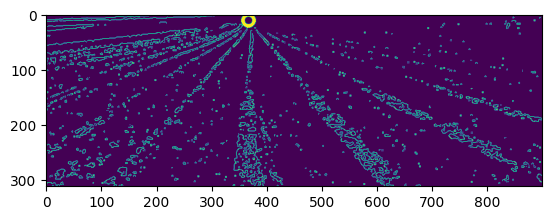

In [30]:
#distinguer entre mode video et mode single image?
vid_folder = '/home/roxane/Desktop/M3_2022/USB/Realsense_18-08-2022_10-46-58/'
video_name = 'CropDetectionVID.avi'
os.chdir("/home/roxane/Desktop/M3_2022/Caterra/vid_assembled")

name_images = obtain_name_images(vid_folder)
images = obtain_images(name_images,vid_folder, VID)


stage = INI_PROCESS

if stage == INI_PROCESS: 
    print('initial process...')
    height_original = images[0].shape[0]
    arr_mask, col_best_mask, _ = initial_process(images[0], 1)
    height, _, _ = arr_mask[0].shape
    stage = SPEED_PROCESS
    #print(images[0].shape)

In [31]:
stage = SPEED_PROCESS


In [32]:
if stage == SPEED_PROCESS:
    print('...speed process...')
    img_save = []
    arr_rows = []
    for idx, sing_img in enumerate(images) : 
        sing_img = sing_img[height_original-height:,:,:]
        #if ((idx%100)==0):
            #arr_mask, col_best_mask, _ = initial_process(sing_img,0)

        image_quick_process, arr_mask, rows_sing_frame = quick_process(sing_img, arr_mask, col_best_mask)
        img_save.append(image_quick_process)
        arr_rows.append(rows_sing_frame)
        #cv2.waitKey(0)
        #cv2.destroyAllWindows()
        
        #print('image nb ', idx)
        #cv2.imshow('results : ', image_quick_process)
        if cv2.waitKey(1) == ord('q'):
            break
    #print(sing_img.shape)
    images_annotated = img_save
cv2.destroyAllWindows()


...speed process...


ValueError: `min_samples` must be in range (0, 0)

In [33]:
cv2.destroyAllWindows()


initial process...
47 lines detected for index  6 with color  [ 43.72550469  -4.84450174 -16.91719952]
step  1 of  6
step  2 of  6
step  3 of  6
step  4 of  6
step  5 of  6
step  6 of  6
VP is :  367 11
...speed process...
...processing done!


"\nif (mode == SING_IMG): \n    print('sing img')\n\n    image_folder = '/home/roxane/Desktop/M3_2022/USB/Realsense_18-08-2022_10-46-58/'\n    name_images = 'rgb001.jpg'\n\n    sing_image = obtain_images(name_images, image_folder, mode)\n\n    if sing_image is not None : \n        image_post_process = annotation(sing_image, 1) \n\n    else : \n        print('None')\n    #image_post_process = ImageAnnotation.annotation(sing_image) \n\n    #cv2.imshow('single analyzed image', image_post_process[0])\n    #cv2.waitKey(0)\n    cv2.destroyAllWindows()\n"

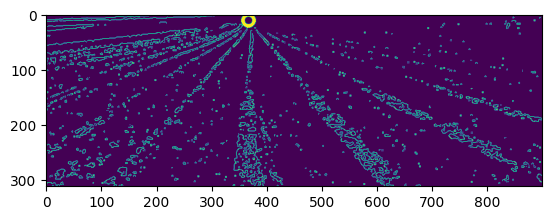

: 

In [13]:



        if stage == ENDED_PROCESS :
            print('...processing done!')
            height, width, _ = images_annotated[0].shape
            """
            for i in range(len(images_annotated)):
                images_annotated[i] = cv2.resize(images_annotated[i], images_annotated[0], interpolation = cv2.INTER_AREA) #this resize makes the video not work?
                s = images_annotated[0].shape
                if ((images_annotated[i].shape) is not s):
                    print('WDF')
            """
        images_post_process = images_annotated


    else : 
        print('error : Images not found')
    
    cv2.destroyAllWindows()

"""
if (mode == SING_IMG): 
    print('sing img')

    image_folder = '/home/roxane/Desktop/M3_2022/USB/Realsense_18-08-2022_10-46-58/'
    name_images = 'rgb001.jpg'

    sing_image = obtain_images(name_images, image_folder, mode)

    if sing_image is not None : 
        image_post_process = annotation(sing_image, 1) 

    else : 
        print('None')
    #image_post_process = ImageAnnotation.annotation(sing_image) 

    #cv2.imshow('single analyzed image', image_post_process[0])
    #cv2.waitKey(0)
    cv2.destroyAllWindows()
"""